# COVID Global Clustering Scratchpad 

Do the same using Global data from John Hopkins University

https://github.com/CSSEGISandData/COVID-19   

https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv


## Clustering thoughts
- Take case + death counts
- Trending pattern (?  what is a good single value metric.. rolling 3 day or some momentum value?)
- Adding population data
- Population density ?
- Median age and age distributions

Attempt to cluster the countries ?


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import pandas as pd
import requests

dfc_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
dfd_graw = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

dfc_g = dfc_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfc_graw.columns[-1], ascending=False)
dfc_g = dfc_g.transpose()  
dfc_g.index = pd.to_datetime(dfc_g.index)
display('cases',dfc_g.tail())
display('chg in cases',dfc_g.tail().diff(axis=0))

dfd_g = dfd_graw.drop(columns=['Lat','Long','Province/State']).groupby(['Country/Region']).sum().sort_values(dfd_graw.columns[-1], ascending=False)
dfd_g = dfd_g.transpose().tail(40)  # last 40 days ?
dfd_g.index = pd.to_datetime(dfd_g.index) 
display('deaths',dfd_g.tail())
display('chg in deaths',dfd_g.tail().diff(axis=0))

#display('details of', dfd_g['Sudan'].tail(15), dfc_g['Sudan'].tail(15))


'cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,China,Iran,Turkey,Belgium,...,MS Zaandam,Holy See,Papua New Guinea,Mauritania,Western Sahara,Burundi,Bhutan,Sao Tome and Principe,South Sudan,Yemen
2020-04-12,555313,166831,156363,121712,127854,85206,83134,71686,56956,29647,...,9,8,2,7,6,5,5,4,4,1
2020-04-13,580619,170099,159516,125394,130072,89570,83213,73303,61049,30589,...,9,8,2,7,6,5,5,4,4,1
2020-04-14,607670,172541,162488,131361,131359,94845,83306,74877,65111,31119,...,9,8,2,7,6,5,5,4,4,1
2020-04-15,636350,177644,165155,134582,134753,99483,83356,76389,69392,33573,...,9,8,2,7,6,5,5,4,4,1
2020-04-16,667801,184948,168941,147091,137698,104145,83403,77995,74193,34809,...,9,8,7,7,6,5,5,4,4,1


'chg in cases'

Country/Region,US,Spain,Italy,France,Germany,United Kingdom,China,Iran,Turkey,Belgium,...,MS Zaandam,Holy See,Papua New Guinea,Mauritania,Western Sahara,Burundi,Bhutan,Sao Tome and Principe,South Sudan,Yemen
2020-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,25306.0,3268.0,3153.0,3682.0,2218.0,4364.0,79.0,1617.0,4093.0,942.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-14,27051.0,2442.0,2972.0,5967.0,1287.0,5275.0,93.0,1574.0,4062.0,530.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-15,28680.0,5103.0,2667.0,3221.0,3394.0,4638.0,50.0,1512.0,4281.0,2454.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-16,31451.0,7304.0,3786.0,12509.0,2945.0,4662.0,47.0,1606.0,4801.0,1236.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Iran,Belgium,Germany,China,Netherlands,...,Fiji,Saint Vincent and the Grenadines,Chad,Saint Lucia,Eritrea,Equatorial Guinea,Saint Kitts and Nevis,Dominica,Rwanda,Central African Republic
2020-04-12,22019,19899,17209,14412,10629,4474,3600,3022,3343,2747,...,0,0,0,0,0,0,0,0,0,0
2020-04-13,23528,20465,17756,14986,11347,4585,3903,3194,3345,2833,...,0,0,0,0,0,0,0,0,0,0
2020-04-14,25831,21067,18056,15748,12129,4683,4157,3294,3345,2955,...,0,0,0,0,0,0,0,0,0,0
2020-04-15,28325,21645,18708,17188,12894,4777,4440,3804,3346,3145,...,0,0,0,0,0,0,0,0,0,0
2020-04-16,32916,22170,19315,17941,13759,4869,4857,4052,3346,3327,...,0,0,0,0,0,0,0,0,0,0


'chg in deaths'

Country/Region,US,Italy,Spain,France,United Kingdom,Iran,Belgium,Germany,China,Netherlands,...,Fiji,Saint Vincent and the Grenadines,Chad,Saint Lucia,Eritrea,Equatorial Guinea,Saint Kitts and Nevis,Dominica,Rwanda,Central African Republic
2020-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-13,1509.0,566.0,547.0,574.0,718.0,111.0,303.0,172.0,2.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-14,2303.0,602.0,300.0,762.0,782.0,98.0,254.0,100.0,0.0,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-15,2494.0,578.0,652.0,1440.0,765.0,94.0,283.0,510.0,1.0,190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-16,4591.0,525.0,607.0,753.0,865.0,92.0,417.0,248.0,0.0,182.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Global Population Comparisons

In [5]:
# GLobal Population 
# https://github.com/datasets/population/blob/master/data/population.csv

df_gpop = pd.read_csv('https://raw.githubusercontent.com/datasets/population/master/data/population.csv')
df_gpop_2016 = df_gpop[df_gpop['Year'] == 2016]
df_gpop_2016 = df_gpop_2016.rename(columns={'Country Name': 'Country/Region'})

display(df_gpop_2016.sort_values(by=['Value'], ascending=False).head(), dfc_g.tail(1).transpose().count())  #262 countries / n countries
df_gmerged = pd.merge(left=dfc_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gpop_2016, on='Country/Region').rename(columns={'Value':'Population'})
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Cases" })

display(df_gmerged.rename(columns={'US':'United States'}).sort_values(by=['Population'], ascending=False).head())

df_gmerged = pd.merge(left=dfd_g.rename(columns={'US':'United States'}).tail(1).transpose(), right=df_gmerged, on='Country/Region')
df_gmerged = df_gmerged.rename(columns={ df_gmerged.columns[1]: "Deaths" })
       
display(df_gmerged.sort_values(by=['Population'], ascending=False).head(), df_gmerged.tail(1).transpose().count())



,Country/Region,Country Code,Year,Value
2711,World,WLD,2016,7426103221
1000,IDA & IBRD total,IBT,2016,6256138021
1531,Low & middle income,LMY,2016,6227752871
1885,Middle income,MIC,2016,5557635482
941,IBRD only,IBD,2016,4687686335


2020-04-16    185
dtype: int64

,Country/Region,Cases,Country Code,Year,Population
6,China,83403,CHN,2016,1378665000
15,India,13430,IND,2016,1324509589
0,United States,667801,USA,2016,322941311
33,Indonesia,5516,IDN,2016,261554226
10,Brazil,30425,BRA,2016,206163058


,Country/Region,Deaths,Cases,Country Code,Year,Population
7,China,3346,83403,CHN,2016,1378665000
18,India,448,13430,IND,2016,1324509589
0,United States,32916,667801,USA,2016,322941311
15,Indonesia,496,5516,IDN,2016,261554226
9,Brazil,1924,30425,BRA,2016,206163058


158    6
dtype: int64

## Add Population Density from worldbank

In [6]:
# population density source
# http://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv   
from zipfile import ZipFile
import requests, zipfile, io
import urllib.request

def get_zip(url):
    urllib.request.urlretrieve(url, "GDP.zip")
    compressed_file = zipfile.ZipFile('GDP.zip')
    files = compressed_file.namelist()
    for f in files:
        if (f.find('API') == 0):
            csv_file = compressed_file.open(f)  # pattern match how?
            return pd.read_csv(csv_file, header=2)
    return None

def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

def add_metric(indicator, colname, dfm, year='2019', debug=True):
    dfnew = get_zip('http://api.worldbank.org/v2/en/indicator/'+indicator+'?downloadformat=csv')
    dfnew = dfnew.fillna(method='ffill', axis=1)[['Country Code', year]].rename(columns={year:colname})

    dfm = pd.merge(left=dfm , right=dfnew, on ='Country Code') 
    display(dfm[dfm['Country/Region'].isin(['Dominica','Japan'])].head()) if debug else None

    dfm[colname] = dfm[colname].astype(str).apply(lambda x: float(x) if isfloat(x) else 0.0).round(2)
    return dfm


## Add demographics from worldbank

In [7]:
#  -- all available https://data.worldbank.org/indicator
#  API docs https://datahelpdesk.worldbank.org/knowledgebase/articles/898581-api-basic-call-structures
#
#   Examples:
# unemployment data http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# hospital beds http://api.worldbank.org/v2/en/indicator/SH.MED.BEDS.ZS?downloadformat=csv
# air flights http://api.worldbank.org/v2/en/indicator/IS.AIR.DPRT?downloadformat=csv
# rail lines http://api.worldbank.org/v2/en/indicator/IS.RRS.TOTL.KM?downloadformat=csv
# employment F http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.FE.ZS?downloadformat=csv
# employment M http://api.worldbank.org/v2/en/indicator/SL.TLF.CACT.MA.ZS?downloadformat=csv
# unemployment http://api.worldbank.org/v2/en/indicator/SL.UEM.TOTL.ZS?downloadformat=csv
# urban pop% http://api.worldbank.org/v2/en/indicator/SP.URB.TOTL.IN.ZS?downloadformat=csv
# pollution EN.ATM.PM25.MC.M3
# slum% indicator/ EN.POP.SLUM.UR.ZS

df_gmerged3 = df_gmerged.copy()  # df_gmerged2 no longer needed

df_gmerged3 = add_metric('IS.AIR.DPRT', 'flights', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.ATM.PM25.MC.M3', 'pollution', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SL.UEM.TOTL.ZS', 'unemp%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.MED.BEDS.ZS', 'hospbeds', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('IS.RRS.TOTL.KM', 'railways', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.URB.TOTL.IN.ZS', 'urbanpop%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.SLUM.UR.ZS', 'slum%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('EN.POP.DNST', 'popdensity%', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('NY.GDP.PCAP.PP.CD', 'GDP/cap', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SE.ADT.LITR.ZS', 'literacy', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('FR.INR.DPST', 'deposit rate', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.DTH.COMM.ZS', 'COD disease', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SH.IMM.IDPT', 'DTP immunized', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('SP.POP.65UP.TO.ZS', 'pop% >= 65', df_gmerged3, year='2019', debug=False)
df_gmerged3 = add_metric('TG.VAL.TOTL.GD.ZS', 'trade%', df_gmerged3, year='2019', debug=False)


df_gmerged3 = df_gmerged3.sort_values(by='Cases', ascending=False).drop(columns=['Year'])

df_x = pd.concat([df_gmerged3.head(10), df_gmerged3[df_gmerged3['Country/Region'].isin(['Japan','United States','Dominica'])]], axis=0)

display(df_gmerged3.shape, df_x[['Country/Region','Cases','flights','railways','hospbeds','popdensity%','pop% >= 65','pollution','GDP/cap','COD disease','urbanpop%','unemp%']])


(159, 20)

,Country/Region,Cases,flights,railways,hospbeds,popdensity%,pop% >= 65,pollution,GDP/cap,COD disease,urbanpop%,unemp%
0,United States,667801,9879630.00,150462.3,2.9,35.77,15.81,7.41,62794.59,5.2,82.26,3.68
2,Spain,184948,641020.00,15618.0,3.0,93.53,19.38,9.70,39715.44,5.1,80.32,13.96
1,Italy,168941,256596.00,16788.3,3.4,205.45,22.75,16.75,41830.43,4.9,70.44,9.89
3,France,147091,597412.00,28241.0,6.5,122.34,20.03,11.81,45342.40,6.0,80.44,8.43
6,Germany,137698,922648.64,33440.0,8.3,237.37,21.46,12.03,53074.54,4.8,77.31,3.04
4,United Kingdom,104145,1242985.00,15961.0,2.8,274.83,18.40,10.47,45973.57,7.7,83.40,3.85
7,China,83403,4692008.00,67515.0,4.2,148.35,10.92,52.66,18236.61,3.8,59.15,4.32
10,Turkey,74193,772925.54,10315.0,2.7,106.96,8.48,44.31,28068.86,4.4,75.14,13.49
5,Belgium,34809,140674.00,3605.0,6.2,377.21,18.79,12.89,51408.00,7.9,98.00,5.59
13,Canada,30808,1475062.59,47687.4,2.7,4.08,17.23,6.43,48130.26,5.6,81.41,5.56


In [8]:
# df_gmerged4 ready to go
df_gmerged4 = df_gmerged3.copy()
df_gmerged4


,Country/Region,Deaths,Cases,Country Code,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
0,United States,32916,667801,USA,322941311,9879630.00,7.41,3.68,2.9,150462.3,82.26,0.0,35.77,62794.59,0.00,0.00,5.2,94.0,15.81,20.83
2,Spain,19315,184948,ESP,46484062,641020.00,9.70,13.96,3.0,15618.0,80.32,0.0,93.53,39715.44,98.44,0.00,5.1,93.0,19.38,51.67
1,Italy,22170,168941,ITA,60627498,256596.00,16.75,9.89,3.4,16788.3,70.44,0.0,205.45,41830.43,99.16,0.00,4.9,95.0,22.75,50.26
3,France,17941,147091,FRA,66721256,597412.00,11.81,8.43,6.5,28241.0,80.44,0.0,122.34,45342.40,0.00,0.79,6.0,96.0,20.03,45.16
6,Germany,4052,137698,DEU,82348669,922648.64,12.03,3.04,8.3,33440.0,77.31,0.0,237.37,53074.54,0.00,0.00,4.8,93.0,21.46,72.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Mauritania,1,7,MRT,4163534,5636.84,47.42,9.55,0.4,728.0,53.67,79.9,4.27,4150.97,53.50,5.67,53.4,81.0,3.14,86.13
138,Bhutan,0,5,BTN,736709,5187.00,37.93,2.34,1.7,0.0,40.90,70.0,19.78,10167.93,66.56,2.00,20.9,97.0,6.00,67.03
123,Burundi,1,5,BDI,10487998,1400.00,38.90,1.43,0.8,0.0,13.03,57.9,435.18,744.18,68.38,0.00,55.8,90.0,2.25,32.01
150,Sao Tome and Principe,0,4,STP,203227,1143.00,28.54,13.37,2.9,0.0,72.80,86.6,219.82,3418.59,92.82,3.80,33.9,95.0,2.93,39.78


# Correlation Matrix

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Deaths,1.000000,0.903648,0.164206,0.671890,-0.159426,0.027217,0.090008,0.662163,0.180630,-0.181630,-0.025627,0.248461,-0.192909,-0.120976,-0.162095,0.091469,0.317097,-0.073405
Cases,0.903648,1.000000,0.229261,0.873542,-0.131218,-0.010429,0.085331,0.821645,0.166588,-0.164552,-0.025279,0.249347,-0.204643,-0.092794,-0.153924,0.085385,0.258520,-0.089705
Population,0.164206,0.229261,1.000000,0.503798,0.267416,-0.049807,-0.036975,0.612453,-0.060774,0.009955,-0.017312,-0.042647,0.024591,-0.026367,-0.018070,0.029798,0.010736,-0.141224
flights,0.671890,0.873542,0.503798,1.000000,-0.055782,-0.070206,0.057644,0.910928,0.141160,-0.138750,-0.024821,0.222829,-0.182516,-0.089135,-0.146960,0.089789,0.181807,-0.101634
pollution,-0.159426,-0.131218,0.267416,-0.055782,1.000000,0.034698,-0.385119,-0.033383,-0.230348,0.477390,-0.100991,-0.172031,0.132855,0.111566,0.416183,-0.111487,-0.466812,-0.100274
unemp%,0.027217,-0.010429,-0.049807,-0.070206,0.034698,1.000000,-0.002011,-0.011623,0.120080,0.026280,-0.125099,-0.148474,0.237484,0.130979,0.009034,-0.098822,0.062347,-0.019466
hospbeds,0.090008,0.085331,-0.036975,0.057644,-0.385119,-0.002011,1.000000,0.138858,0.388271,-0.565877,0.332303,0.305930,-0.010130,-0.163978,-0.513351,0.295807,0.601188,0.223852
railways,0.662163,0.821645,0.612453,0.910928,-0.033383,-0.011623,0.138858,1.000000,0.142949,-0.172386,-0.042580,0.182165,-0.167972,-0.069401,-0.162519,0.078569,0.251617,-0.128805
urbanpop%,0.180630,0.166588,-0.060774,0.141160,-0.230348,0.120080,0.388271,0.142949,1.000000,-0.478795,0.181979,0.606855,-0.022595,-0.110195,-0.532877,0.334991,0.408456,0.181994
slum%,-0.181630,-0.164552,0.009955,-0.138750,0.477390,0.026280,-0.565877,-0.172386,-0.478795,1.000000,-0.113728,-0.551982,-0.078594,0.289491,0.799900,-0.276597,-0.605509,-0.244386


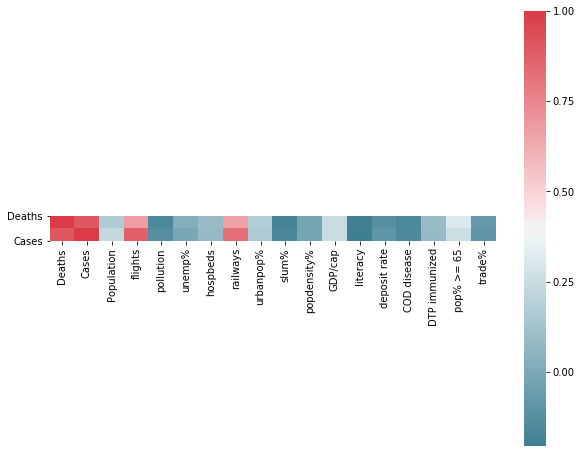

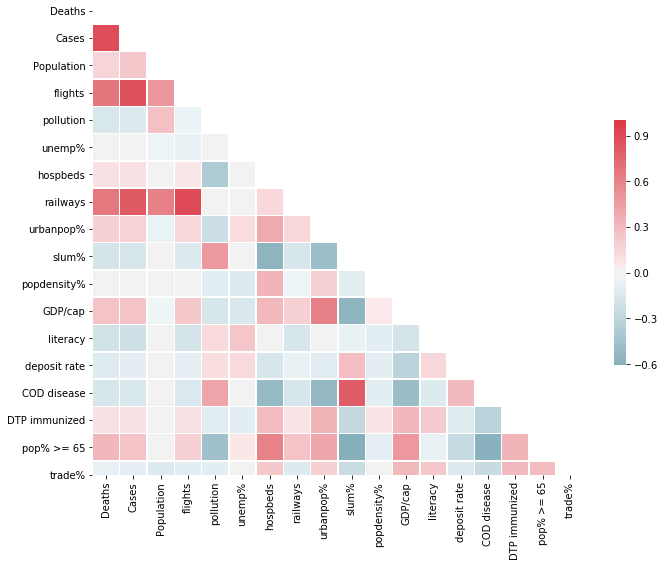

In [9]:
import seaborn as sns

df_corr = df_gmerged4.corr()

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_corr.iloc[0:2,:], mask=np.zeros_like(df_corr.iloc[0:2,:], dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_corr


## Scaling / Normalization

In [17]:
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'
scaler = StandardScaler()

df_sc = df_gmerged4.copy().set_index('Country/Region').drop(columns=['Country Code'])
display('orig',df_sc.head(2))

df_sc = pd.DataFrame(scaler.fit_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
display('scale',df_sc.head(2))

# df_sc = pd.DataFrame(scaler.inverse_transform(df_sc), index=df_sc.index, columns=df_sc.columns)
# display('inverse',df_sc.head(2))

'orig'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,32916,667801,322941311,9879630.0,7.41,3.68,2.9,150462.3,82.26,0.0,35.77,62794.59,0.00,0.0,5.2,94.0,15.81,20.83
Spain,19315,184948,46484062,641020.0,9.70,13.96,3.0,15618.0,80.32,0.0,93.53,39715.44,98.44,0.0,5.1,93.0,19.38,51.67


'scale'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
United States,8.221962,11.098789,1.809402,10.876939,-1.012400,-0.533644,0.018517,9.518885,0.955201,-0.882278,-0.183451,1.814318,-1.967469,-0.814337,-0.772788,0.406128,1.074007,-1.121848
Spain,4.732600,2.917920,0.026889,0.472386,-0.894881,1.370712,0.060101,0.686980,0.871687,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125


# Misc Clustering Techniques

In [18]:
# sample from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans

from sklearn.cluster import KMeans
import numpy as np

#cols = features
#rows = examples
X = np.array([[1, 2,1],[1, 4,3],[1, 0,4],[1, 4,3], 
              [4, 8,4],[4, 9,3],[4, 10,4],
              [10,2,1],[10,4,4],[10,0,2]])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)       # 3 clusters trained on 13 samples, 3 features

display(f'inertia: {kmeans.inertia_} iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels
display(kmeans.cluster_centers_)                           # k-centers
display(f'kmeans.predict([[0,0,0], [12,100,30000]]): {kmeans.predict([[0,0,0], [12,100,30000]])}')  # evaluate 2 arb points
display(f'score {kmeans.score([[0,0,0], [12,100,30000]])}') # score
display(f'transform: {kmeans.transform([[0,0,0], [12,100,30000]])}')  # what does this do, distance of each pt ?
display(f'kmeans.predict([[1,4,4], [1,10,4]]): {kmeans.predict([[1,4,4], [1,10,4]])}')   # evaluate 2 arb points
display(f'score {kmeans.score([[1,4,4], [1,10,4]])}')       # score
display(f'transform: {kmeans.transform([[1,4,4], [1,10,4]])}')  


'inertia: 31.083333333333332 iters: 2'

'labels: [2 2 2 2 0 0 0 1 1 1]'

array([[ 4.        ,  9.        ,  3.66666667],
       [10.        ,  2.        ,  2.33333333],
       [ 1.        ,  2.5       ,  2.75      ]])

'kmeans.predict([[0,0,0], [12,100,30000]]): [2 0]'

'score -899788373.2569444'

'transform: [[1.05092552e+01 1.04615699e+01 3.84870108e+00]\n [2.99964724e+04 2.99978268e+04 2.99974105e+04]]'

'kmeans.predict([[1,4,4], [1,10,4]]): [2 0]'

'score -13.9236111111111'

'transform: [[ 5.84047182  9.36897955  1.95256242]\n [ 3.17979734 12.15638835  7.60345316]]'

In [21]:
# kmeans apply to a subset of my data

df_gm5 = df_sc.copy()
df_train = pd.concat([df_gm5.iloc[0:10,6:10],df_gm5.loc[['Japan','Pakistan','France','Italy']].iloc[:,6:10]], axis=0)
df_test = df_gm5.iloc[20:22,6:10]

display('train',df_train)
display('test',df_test)

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'inertia: {kmeans.inertia_} iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels
display(kmeans.cluster_centers_)                           # k-centers
display(f'kmeans.predict x2: {kmeans.predict(df_test)}')  # evaluate 2 arb points
display(f'score {kmeans.score(df_test)}') # score
display(f'transform: {kmeans.transform(df_test)}')  # what does this do, distance of each pt ?

df_train['cluster'] = kmeans.labels_
df_test['cluster'] = kmeans.predict(df_test)
display('train',df_train)
display('test',df_test)

'train'

,hospbeds,railways,urbanpop%,slum%
Country/Region,,,,
United States,0.018517,9.518885,0.955201,-0.882278
Spain,0.060101,0.686980,0.871687,-0.882278
Italy,0.226437,0.763632,0.446370,-0.882278
France,1.515545,1.513750,0.876853,-0.882278
Germany,2.264060,1.854269,0.742112,-0.882278
United Kingdom,-0.023067,0.709446,1.004276,-0.882278
China,0.559110,4.086081,-0.039645,0.007618
Turkey,-0.064652,0.339650,0.648697,-0.462049
Belgium,1.390793,-0.099836,1.632781,-0.882278


'test'

,hospbeds,railways,urbanpop%,slum%
Country/Region,,,,
Chile,-0.272572,-0.197099,1.183357,-0.564458
Japan,4.384850,0.767784,1.358133,-0.882278


'inertia: 29.76007997253885 iters: 2'

'labels: [1 0 0 2 2 0 0 0 2 0 2 0 2 0]'

array([[-2.27535807e-03,  1.28889838e+00,  4.11124453e-01,
        -5.17667889e-01],
       [ 1.85167070e-02,  9.51888537e+00,  9.55201141e-01,
        -8.82278029e-01],
       [ 2.21415878e+00,  1.10994338e+00,  1.09734662e+00,
        -8.82278029e-01]])

'kmeans.predict x2: [0 2]'

'score -7.776765452089066'

'transform: [[1.69699171 9.72821399 2.8285328 ]\n [4.53301207 9.78820703 2.21291315]]'

'train'

,hospbeds,railways,urbanpop%,slum%,cluster
Country/Region,,,,,
United States,0.018517,9.518885,0.955201,-0.882278,1
Spain,0.060101,0.686980,0.871687,-0.882278,0
Italy,0.226437,0.763632,0.446370,-0.882278,0
France,1.515545,1.513750,0.876853,-0.882278,2
Germany,2.264060,1.854269,0.742112,-0.882278,2
United Kingdom,-0.023067,0.709446,1.004276,-0.882278,0
China,0.559110,4.086081,-0.039645,0.007618,0
Turkey,-0.064652,0.339650,0.648697,-0.462049,0
Belgium,1.390793,-0.099836,1.632781,-0.882278,2


'test'

,hospbeds,railways,urbanpop%,slum%,cluster
Country/Region,,,,,
Chile,-0.272572,-0.197099,1.183357,-0.564458,0
Japan,4.384850,0.767784,1.358133,-0.882278,2


In [30]:
## apply to all cols
from sklearn.model_selection import train_test_split
df_gm5 = df_sc.copy()
df_train,df_test = train_test_split(df_gm5,test_size=0.2)


display('train',df_train.shape, df_train.head(10))
display('test',df_test.shape, df_test)

kmeans = KMeans(n_clusters=3, random_state=0).fit(df_train) # train on sample rows

display(f'inertia: {kmeans.inertia_} iters: {kmeans.n_iter_}')    # training info 
display(f'labels: {kmeans.labels_}')                       # k-labels
display(kmeans.cluster_centers_)                           # k-centers
display(f'kmeans.predict x2: {kmeans.predict(df_test)}')  # evaluate 2 arb points
display(f'score {kmeans.score(df_test)}') # score
display(f'transform: {kmeans.transform(df_test)}')  # what does this do, distance of each pt ?

df_train['cluster'] = kmeans.labels_
df_test['cluster'] = kmeans.predict(df_test)
display('train',df_train)
display('test',df_test)

'train'

(127, 18)

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
China,0.635723,1.197466,8.616390,5.034622,1.309760,-0.415085,0.559110,4.086081,-0.039645,0.007618,-0.115024,-0.143651,0.753958,-0.473995,-0.839924,0.684946,0.334015,-0.757250
Sweden,0.119284,-0.003150,-0.208845,-0.035200,-1.075522,-0.014948,-0.106236,0.299893,1.177761,-0.882278,-0.189997,1.393102,-1.967469,-0.567022,-0.772788,0.573418,1.723202,-0.022782
Central African Republic,-0.222700,-0.215409,-0.243569,-0.248727,1.523758,-0.533644,-0.771582,-0.335953,-0.805474,2.412456,-0.200639,-0.907218,-0.916443,-0.258446,2.032537,-2.214763,-0.890225,-0.953700
Namibia,-0.222700,-0.215341,-0.257623,-0.233155,-0.091234,2.539631,-0.064652,-0.335953,-0.432246,0.290125,-0.203386,-0.457168,0.604735,0.517534,1.341996,0.127309,-0.767649,0.789932
Haiti,-0.221930,-0.214918,-0.202934,-0.248632,-0.621867,1.337367,-0.896334,-0.335953,-0.206242,1.745034,0.040117,-0.862982,-0.233838,0.576526,0.430865,-1.266781,-0.569410,-0.005024
Timor-Leste,-0.222700,-0.215307,-0.264965,-0.249533,-0.404276,-0.372478,1.266041,-0.335953,-1.269535,-0.882278,-0.153364,-0.608478,-0.054545,-0.669125,1.164565,-0.207272,-0.664747,-1.041936
Spain,4.732600,2.917920,0.026889,0.472386,-0.894881,1.370712,0.060101,0.686980,0.871687,-0.882278,-0.148344,0.800173,0.798922,-0.814337,-0.777583,0.350364,1.614246,-0.266125
Moldova,-0.208846,-0.179118,-0.254759,-0.234228,-0.558745,-0.202049,1.224456,-0.260566,-0.750803,-0.882278,-0.130116,-0.625475,0.824776,0.204419,-0.820742,0.350364,0.417245,0.354024
Hungary,-0.186270,-0.187623,-0.209549,-0.042829,-0.575167,-0.585514,1.723466,0.127898,0.485544,-0.882278,-0.139604,0.421702,0.817470,-0.800724,-0.935832,0.684946,1.580954,2.643444


'test'

(32, 18)

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%
Country/Region,,,,,,,,,,,,,,,,,,
Monaco,-0.221930,-0.214037,-0.272581,-0.249530,-1.392670,-1.215359,4.551187,-0.335953,1.718878,-0.882278,11.462166,-0.945005,-1.967469,-0.814337,-1.022150,0.684946,-1.318482,-1.699822
Rwanda,-0.222700,-0.213274,-0.197590,-0.228767,0.824801,-1.024553,-0.522077,-0.335953,-1.845091,0.996391,0.097895,-0.846067,0.090182,0.408624,1.011111,0.573418,-0.873579,-0.621289
Kuwait,-0.221930,-0.189792,-0.247314,-0.197221,1.724926,-0.811517,-0.355740,-0.335953,1.718878,-0.882278,-0.064078,2.258263,0.732039,-0.435423,-0.312427,0.684946,-0.932596,0.434491
Grenada,-0.222700,-0.215375,-0.272116,-0.249533,-0.226715,-1.215359,0.351190,-0.335953,-1.024590,-0.670398,-0.005948,-0.261375,0.803419,-0.498954,-0.451494,0.517655,0.137289,-0.548591
Sao Tome and Principe,-0.222700,-0.215545,-0.271516,-0.248246,0.071959,1.261415,0.018517,-0.335953,0.547964,2.175856,-0.071585,-0.794786,0.640987,0.047862,0.603500,0.461891,-0.875092,-0.596039
Paraguay,-0.220648,-0.212664,-0.229125,-0.244786,-0.781467,-0.324313,-0.646829,-0.307068,0.064962,-0.260763,-0.194549,-0.347397,0.674710,0.079627,-0.365176,0.071546,-0.345446,-0.164293
Bangladesh,-0.207307,-0.188978,0.745722,-0.135355,1.730058,-0.439167,-0.854750,-0.147518,-1.009093,1.063486,0.548227,-0.752902,0.109573,0.696780,0.205480,0.629182,-0.537631,-0.679558
Lithuania,-0.214490,-0.196501,-0.254333,-0.246859,-0.784546,-0.039030,1.848218,-0.210788,0.327557,-0.882278,-0.178126,0.613240,0.837703,-0.814337,-0.849514,0.294600,1.664184,1.931451
Peru,-0.152405,-0.003980,-0.073425,-0.090710,-0.120485,-0.602186,-0.522077,-0.228603,0.767941,0.325438,-0.190003,-0.311446,0.685670,-0.213067,-0.048678,-0.151509,-0.094242,-0.547759


'inertia: 1270.1190241269876 iters: 8'

'labels: [1 1 0 2 0 2 1 2 1 0 0 0 2 0 2 0 2 1 1 1 1 1 1 0 1 2 2 2 1 2 0 0 2 2 0 1 2\n 0 2 2 2 2 1 2 1 1 2 2 1 0 2 1 2 2 0 0 0 0 0 0 2 0 0 0 2 1 2 2 2 2 1 0 1 2\n 2 2 0 2 2 0 0 2 1 2 0 2 2 0 1 2 0 0 2 0 0 0 2 2 2 2 0 2 2 2 2 2 2 2 0 1 2\n 0 1 1 1 2 2 0 0 2 0 1 2 1 2 1 2]'

array([[-0.21562833, -0.20213546,  0.12702379, -0.18944785,  0.61861882,
        -0.2115491 , -0.82894654, -0.16311766, -1.00756949,  1.13954598,
        -0.13630569, -0.76630921, -0.3149021 ,  0.3325854 ,  1.29109037,
        -0.7420313 , -0.82833554, -0.39539133],
       [ 0.41240281,  0.29709179,  0.15512565,  0.25179554, -0.71841388,
        -0.16487595,  0.96940715,  0.38115963,  0.66080817, -0.85261483,
        -0.11616547,  1.03540388, -0.58444217, -0.68288964, -0.78285795,
         0.43958576,  1.52844322,  0.30046298],
       [-0.19481099, -0.15791111, -0.12991668, -0.11862701,  0.02980689,
         0.31677477,  0.04002574, -0.16523256,  0.22764036, -0.29205832,
        -0.08729212, -0.05907992,  0.56147704,  0.11855127, -0.44413546,
         0.2551812 , -0.16278277,  0.15822969]])

'kmeans.predict x2: [1 0 2 2 0 2 0 1 2 2 2 2 0 2 2 1 1 1 0 2 2 1 0 0 2 0 0 0 2 2 2 1]'

'score -836.8239378136352'

'transform: [[13.91565333 13.00973583 13.19513604]\n [ 1.93636657  5.62714031  3.61177965]\n [ 5.44477985  4.51999647  3.67473609]\n [ 3.79176915  3.55544816  2.33191749]\n [ 3.13641822  5.31511657  3.15076091]\n [ 3.19092342  3.605272    1.37993643]\n [ 2.38440302  5.43348601  3.35059857]\n [ 6.08438125  2.68954436  3.53672173]\n [ 2.98667063  3.60803976  1.707125  ]\n [ 2.86426236  3.72647197  1.65773346]\n [ 4.13706118  3.76565831  1.91219511]\n [ 5.88144589  4.62630337  4.32575818]\n [ 1.38173808  5.90883117  3.92384406]\n [ 4.74762977  2.27251476  1.88309064]\n [ 4.98556895  5.85092357  4.31062788]\n [ 9.11531713  7.2240419   7.54296117]\n [ 6.57904637  2.86637121  4.70852122]\n [21.20838274 19.56477313 20.80317926]\n [ 6.28901631  7.90402606  7.22477245]\n [ 3.85406614  3.54823798  1.62524939]\n [ 4.35705488  3.72956919  2.10005755]\n [ 6.75399971  3.94809211  5.56654406]\n [ 2.60463985  5.54897884  3.29559804]\n [ 1.70049372  5.62019889  3.86772275]\n [ 5.87680373  4.40020283  3

C:\Users\dougc\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\dougc\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


'train'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%,cluster
Country/Region,,,,,,,,,,,,,,,,,,,
China,0.635723,1.197466,8.616390,5.034622,1.309760,-0.415085,0.559110,4.086081,-0.039645,0.007618,-0.115024,-0.143651,0.753958,-0.473995,-0.839924,0.684946,0.334015,-0.757250,1
Sweden,0.119284,-0.003150,-0.208845,-0.035200,-1.075522,-0.014948,-0.106236,0.299893,1.177761,-0.882278,-0.189997,1.393102,-1.967469,-0.567022,-0.772788,0.573418,1.723202,-0.022782,1
Central African Republic,-0.222700,-0.215409,-0.243569,-0.248727,1.523758,-0.533644,-0.771582,-0.335953,-0.805474,2.412456,-0.200639,-0.907218,-0.916443,-0.258446,2.032537,-2.214763,-0.890225,-0.953700,0
Namibia,-0.222700,-0.215341,-0.257623,-0.233155,-0.091234,2.539631,-0.064652,-0.335953,-0.432246,0.290125,-0.203386,-0.457168,0.604735,0.517534,1.341996,0.127309,-0.767649,0.789932,2
Haiti,-0.221930,-0.214918,-0.202934,-0.248632,-0.621867,1.337367,-0.896334,-0.335953,-0.206242,1.745034,0.040117,-0.862982,-0.233838,0.576526,0.430865,-1.266781,-0.569410,-0.005024,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sri Lanka,-0.220904,-0.211580,-0.136116,-0.210764,-0.823035,-0.437315,0.309606,-0.233665,-1.790419,-0.006507,0.004840,-0.352945,0.609794,1.193679,-0.662493,0.684946,0.265918,-0.625174,2
Australia,-0.206537,-0.106128,-0.116851,0.499824,-0.953897,-0.239099,0.392774,0.242341,1.116632,-0.882278,-0.203216,1.325189,-1.967469,-0.365086,-0.801560,0.461891,1.051308,-0.746706,1
Costa Rica,-0.221674,-0.204735,-0.241237,-0.204789,-0.585431,0.979837,-0.688414,-0.280411,0.829500,-0.688055,-0.145682,-0.168501,0.782623,0.097779,-0.715242,0.406128,0.126696,-0.437325,2


'test'

,Deaths,Cases,Population,flights,pollution,unemp%,hospbeds,railways,urbanpop%,slum%,popdensity%,GDP/cap,literacy,deposit rate,COD disease,DTP immunized,pop% >= 65,trade%,cluster
Country/Region,,,,,,,,,,,,,,,,,,,
Monaco,-0.221930,-0.214037,-0.272581,-0.249530,-1.392670,-1.215359,4.551187,-0.335953,1.718878,-0.882278,11.462166,-0.945005,-1.967469,-0.814337,-1.022150,0.684946,-1.318482,-1.699822,1
Rwanda,-0.222700,-0.213274,-0.197590,-0.228767,0.824801,-1.024553,-0.522077,-0.335953,-1.845091,0.996391,0.097895,-0.846067,0.090182,0.408624,1.011111,0.573418,-0.873579,-0.621289,0
Kuwait,-0.221930,-0.189792,-0.247314,-0.197221,1.724926,-0.811517,-0.355740,-0.335953,1.718878,-0.882278,-0.064078,2.258263,0.732039,-0.435423,-0.312427,0.684946,-0.932596,0.434491,2
Grenada,-0.222700,-0.215375,-0.272116,-0.249533,-0.226715,-1.215359,0.351190,-0.335953,-1.024590,-0.670398,-0.005948,-0.261375,0.803419,-0.498954,-0.451494,0.517655,0.137289,-0.548591,2
Sao Tome and Principe,-0.222700,-0.215545,-0.271516,-0.248246,0.071959,1.261415,0.018517,-0.335953,0.547964,2.175856,-0.071585,-0.794786,0.640987,0.047862,0.603500,0.461891,-0.875092,-0.596039,0
Paraguay,-0.220648,-0.212664,-0.229125,-0.244786,-0.781467,-0.324313,-0.646829,-0.307068,0.064962,-0.260763,-0.194549,-0.347397,0.674710,0.079627,-0.365176,0.071546,-0.345446,-0.164293,2
Bangladesh,-0.207307,-0.188978,0.745722,-0.135355,1.730058,-0.439167,-0.854750,-0.147518,-1.009093,1.063486,0.548227,-0.752902,0.109573,0.696780,0.205480,0.629182,-0.537631,-0.679558,0
Lithuania,-0.214490,-0.196501,-0.254333,-0.246859,-0.784546,-0.039030,1.848218,-0.210788,0.327557,-0.882278,-0.178126,0.613240,0.837703,-0.814337,-0.849514,0.294600,1.664184,1.931451,1
Peru,-0.152405,-0.003980,-0.073425,-0.090710,-0.120485,-0.602186,-0.522077,-0.228603,0.767941,0.325438,-0.190003,-0.311446,0.685670,-0.213067,-0.048678,-0.151509,-0.094242,-0.547759,2


## Dimension Reduction

In [ ]:

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'



# Pop Density vs Case counts

In [ ]:
max_ctys = 30
fig,ax1 = plt.subplots(figsize=(10, 8)) 

df_gmerged_h = df_gmerged2[df_gmerged2['Cases'] > 1000].sort_values(by=['popdensity'],ascending=False).head(max_ctys)

ax1.set_xlabel('Cases')  
ax1.set_xscale('linear')
ax1.barh(df_gmerged_h['Country/Region'], df_gmerged_h['Cases'], color='xkcd:green')
for n,i in enumerate(ax1.patches):
    ax1.text(i.get_width()+.02, i.get_y()+.5,'density: '+str(df_gmerged_h['popdensity'].iloc[n:n+1].round(2).item()) + ', pop: '+str(df_gmerged_h['Population'].iloc[n:n+1].div(1000000).round(0).item()) +'M, '+str(df_gmerged_h['% of pop'].iloc[n:n+1].round(2).item())  +'%', color='xkcd:blue')

# ax2 = ax1.twiny()
# ax2.set_xscale('linear')
# ax2.set(xlim=[0, 10])   # get max min +/- buffer
# ax2.set_xlabel('Population density', color='xkcd:red')  
# ax2.spines['top'].set_color('red')
# ax2.tick_params(axis='x', colors='red')
# ax2.barh(df_gmerged_h['Country/Region'], df_gmerged_h['popdensity'], color='xkcd:red')
# for n,i in enumerate(ax2.patches):
#     ax2.text(i.get_width()+.02, i.get_y()+.5,str(df_gmerged_h['popdensity'].iloc[n:n+1].item()), color='xkcd:red')

plt.title('Top Population Density Countries > 1000 cases')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# read from JSON directly WIP -- would be more optimal than above but scrap for now
# EN.ATM.PM25.MC.M3 - polution
# able to aggrecate and get last value, not sure what source= is    ?source=2&format=json&mrnev=1&per_page=500
#   http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000
#jurl = 'http://api.worldbank.org/v2/country/all/indicator/EN.ATM.PM25.MC.M3;SH.MED.BEDS.ZS;IS.AIR.DPRT;IS.RRS.TOTL.KM;SP.URB.TOTL.IN.ZS;SP.POP.TOTL;SL.UEM.TOTL.ZS?source=2&format=json&mrnev=1&per_page=5000'
    
#r = requests.get(jurl)
#display(r.text)
#    
#pd.read_json(r.text)

